# Preprocessing, Modeling, and Evaluating the Data

We will use four supervised learning classification techniques:
* [Logistic Regression](#Logistic-Regression) 
* [Support Vector Machine (SVM)](#Support-Vector-Machine)
* [Random Forest](#Random-Forest)
* [Extreme Gradient Boosting (XGBoost)](#XGBoost)


We will also apply the oversampling technique [SMOTE](#Oversampling:-using-SMOTE), which is used for imbalanced data, to our training data. We will compare our models with and without SMOTE. 
In addition, before feeding the data into our logistic regression and SVM models, we will further preprocess our data through [standardization](#Scaling). Tree-based models do not require any scaling. We will also perform hyperparameter tuning on all our model types and then evaluate the models we created based on various classification metrics.

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import preprocessing modules
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Import metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Import cross validation modules
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Import Classification Algorithms
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb

plt.style.use('seaborn')

### Load the data

In [2]:
df = pd.read_csv(r"C:\Users\Mateo\Desktop\capstone_test_branch\Capstone2\dataset_wrangled\selection_correlation.csv", index_col='symbol')

In [3]:
df.head()

,target,FCF,Net Receivables,Goodwill,Other Current Assets,Total Liabilities & Equity,ROTA,Shares Outstanding,Deferred Asset Charges
symbol,,,,,,,,,
K,0,2.444000e+09,1.424000e+09,5.051000e+09,322000000.0,1.547400e+10,0.183598,3.628514e+08,0.0
SWK,0,1.208300e+09,1.578500e+09,7.562700e+09,468600000.0,1.653510e+10,0.045219,1.486392e+08,0.0
AAP,1,7.410070e+08,2.775950e+08,1.998350e+08,42761000.0,5.564774e+09,0.119145,7.308918e+07,0.0
AVY,0,4.488000e+08,1.119900e+09,7.511000e+08,126200000.0,4.610600e+09,0.092591,9.735160e+07,263400000.0
CERN,0,1.048742e+09,6.745400e+08,3.074220e+08,175488000.0,4.098364e+09,0.143485,3.434086e+08,0.0


# Data Preprocessing

### Split the data into test and train sets

In [4]:
X = df.drop('target', axis=1)
y = df['target']

In [5]:
# Random Seed
seed = 42

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [7]:
X_train.shape, X_test.shape

((344, 8), (87, 8))

In [8]:
y_train.shape, y_test.shape

((344,), (87,))

### Oversampling:  using SMOTE
SMOTE stands for Synthetic Minority Oversampling Technique. It is used to synthesize new instances from the existing instances in the minority class. It does so by selecting instances that are close in the feature space through k-Nearest Neighbor.

> SMOTE first selects a minority class instance, $a$, at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors, $b$, at random and connecting $a$ and $b$ to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances $a$ and $b$.

-[Imbalanced Learning: Foundations, Algorithms, and Applications](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)


In [9]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0))) 
  
sm = SMOTE(random_state = seed) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train) 
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))


Before OverSampling, counts of label '1': 70
Before OverSampling, counts of label '0': 274 

After OverSampling, the shape of train_X: (548, 8)
After OverSampling, the shape of train_y: (548,) 

After OverSampling, counts of label '1': 274
After OverSampling, counts of label '0': 274


###  Metrics Report  
Function to output a summary of the classification metrics. The scores will be used to evaluate and compare each model.

In [10]:
# Empty lits to be used later on as a summary table
list_model=[]
list_accuracy=[]
list_recall=[]
list_precision=[]
list_f1=[]
list_auc =[]

In [11]:
def report_metrics(classifier, X, y, append=False, model_name=None):
    y_pred = classifier.predict(X)
    y_prob = classifier.predict_proba(X)[:,1]
    accuracy = accuracy_score(y, y_pred)
    recall = recall_score(y, y_pred)
    precision = precision_score(y, y_pred)
    f1 = f1_score(y, y_pred, labels=np.unique(y_pred))
    fpr, tpr, thresholds = roc_curve(y, y_prob)
    roc_auc = auc(fpr, tpr)


    list_labels = ['Accuracy','Recall','Precision','F1 Score', 'AUC']
    list_scores = [accuracy, recall, precision, f1, roc_auc]
    
    # Summary of scores
    report  = pd.Series(list_scores, list_labels)
    print(report)
    
    # Barplot comparing the classification metrics for the model
    report.plot(kind='bar', yticks=np.arange(0.1, 1.1, .1))
    
    # Append scores to summary lists
    if append==True:
        list_model.append(model_name)
        list_accuracy.append(accuracy)
        list_recall.append(recall)
        list_precision.append(precision)
        list_f1.append(f1)
        list_auc.append(roc_auc)

### Dummy Model: used as a baseline classifier

In [12]:
# This dummy classifier simply predicts the mode
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [13]:
# The dummy classification model is simply predicting 0 i.e. the stocks will not return 20%
dummy_pred = dummy.predict(X_test)
dummy_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [14]:
confusion_matrix(y_test, dummy_pred)

array([[69,  0],
       [18,  0]], dtype=int64)

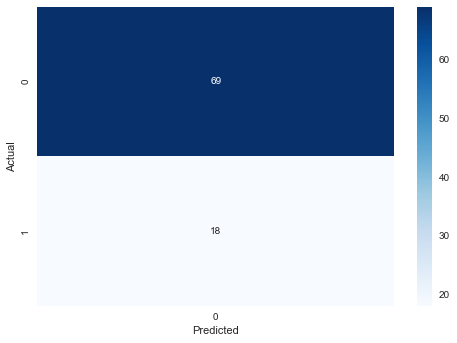

In [15]:
confusion_df = pd.crosstab(y_test, dummy.predict(X_test), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_df, annot=True, cmap='Blues')

Since our dummy model is just predicting 0, there are no true positive values and only true negatives. We can still derive accuracy and use it as a baseline for our other models.

In [16]:
print('Dummy Classifier Score on Training Data:', dummy.score(X_train, y_train))
print('Dummy Classifier Score on Testing Data:', dummy.score(X_test, y_test))

Dummy Classifier Score on Training Data: 0.7965116279069767
Dummy Classifier Score on Testing Data: 0.7931034482758621


# Scaling 
Feature scaling limits the range for each variable, so that the variables can be compared.
Feature scaling also helps the algorithm converge more quickly. 
Scaling is especially useful for Euclidean Distance based models.

We will scale our data through standardization, and then input the newly scaled data into logistic regression and SVM models.

The standardization equation is: $$Z = \frac{x-\bar{x}}{\sigma} $$

In [17]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

X_test_scaled = scaler.transform(X_test)

In [18]:
# scale training data modified by SMOTE
scaler_res = StandardScaler()
scaler_res.fit(X_train_res)
X_train_res_scaled = scaler_res.transform(X_train_res)

# Logistic Regression

In [19]:
lr = LogisticRegression(max_iter=1000, random_state=seed)
lr.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [20]:
lr_smote = LogisticRegression(max_iter=1000, random_state=seed)
lr_smote.fit(X_train_res_scaled, y_train_res)

LogisticRegression(max_iter=1000, random_state=42)

**Training Results**

Accuracy     0.796512
Recall       0.000000
Precision    0.000000
F1 Score     0.000000
AUC          0.691189
dtype: float64


C:\Users\Mateo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


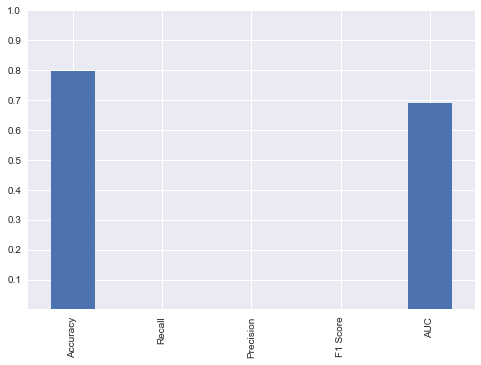

In [21]:
report_metrics(lr, X_train_scaled, y_train)

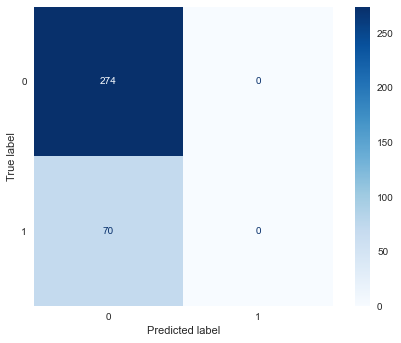

In [22]:
plot_confusion_matrix(lr, X_train_scaled, y_train, cmap='Blues')
plt.grid(None)

Accuracy     0.653285
Recall       0.824818
Precision    0.614130
F1 Score     0.704050
AUC          0.690367
dtype: float64


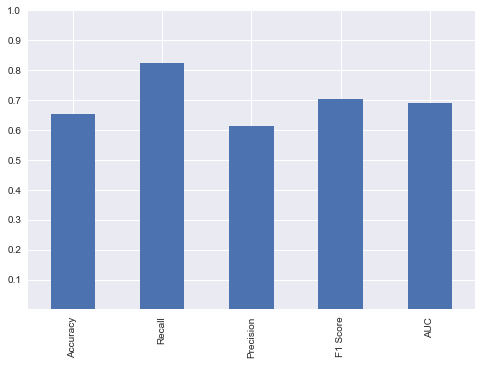

In [23]:
report_metrics(lr_smote, X_train_res_scaled, y_train_res)

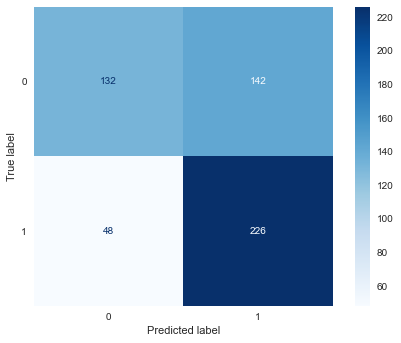

In [24]:
plot_confusion_matrix(lr_smote, X_train_res_scaled, y_train_res, cmap='Blues')
plt.grid(None)

**Testing Results**

Accuracy     0.793103
Recall       0.000000
Precision    0.000000
F1 Score     0.000000
AUC          0.599839
dtype: float64


C:\Users\Mateo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


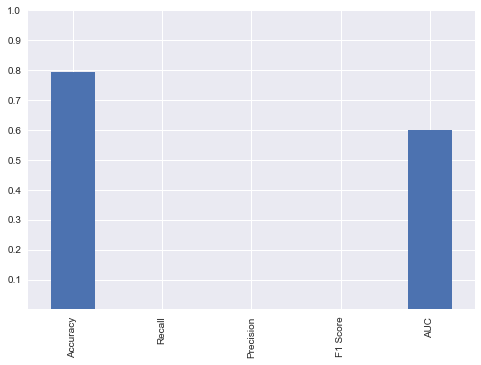

In [25]:
report_metrics(lr, X_test_scaled, y_test, append=True, model_name='lr_base')

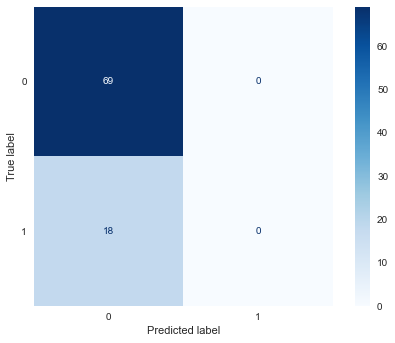

In [26]:
plot_confusion_matrix(lr, X_test_scaled, y_test, cmap='Blues')
plt.grid(None)

Accuracy     0.436782
Recall       0.777778
Precision    0.237288
F1 Score     0.363636
AUC          0.607085
dtype: float64


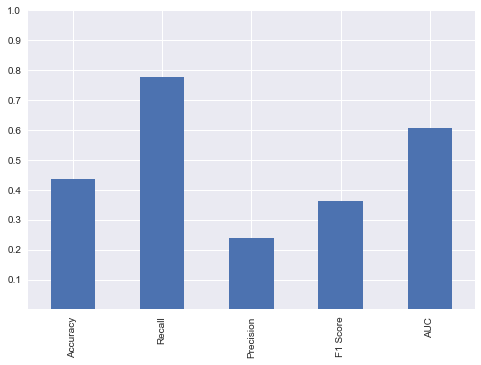

In [27]:
report_metrics(lr_smote, X_test_scaled, y_test, append=True, model_name='lr_smote')

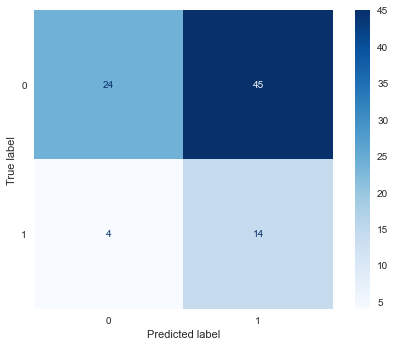

In [28]:
plot_confusion_matrix(lr_smote, X_test_scaled, y_test, cmap='Blues')
plt.grid(None)

### Cross Validation with GridSearch

Since the logistic regression model fit on the SMOTE dataset performed better overall, we will hyperparameter tune it using a gridsearch and cross validation. For logistic regression, the hyperparameter C is the main hyperparameter that affects regularization.
Smaller C values increase the regularization strength leading to more underfitting models;
bigger C values increase the complexity of the model leading to potentially more overfitting 

In [29]:
# Tuning logistic regression model with gridsearch and cross validation
from sklearn.model_selection import GridSearchCV

C_range = [0.001, .01, 0.1, 1, 10, 100] # Inverse of regularization strength. Smaller values = stronger regularization
class_weight = ['balanced']
solvers = ['newton-cg', 'lbfgs'] # optimization algorithm
penalty = ['l2'] # Note: penalty suport is dependent on type of solver. newton-cg and lbfgs can only handle L2
param_grid={'C':C_range,'solver':solvers,'penalty':penalty, 'class_weight':class_weight}


lr_cv1 = GridSearchCV(lr_smote, param_grid, cv=5)
lr_cv1.fit(X_train_res_scaled, y_train_res)

print(lr_cv1.best_params_, lr_cv1.best_score_)

{'C': 100, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cg'} 0.6369140950792327


In [30]:
C_range = [0.001, .01, 0.1, 1, 10, 100] # Inverse of regularization strength. Smaller values = stronger regularization
solvers = ['liblinear'] # optimization algorithm
penalty = ['l1'] # liblinear can handle L1 penalty
param_grid={'C':C_range,'solver':solvers,'penalty':penalty, 'class_weight':class_weight}


lr_cv2 = GridSearchCV(lr_smote, param_grid, cv=5)
lr_cv2.fit(X_train_res_scaled, y_train_res)

print(lr_cv2.best_params_, lr_cv2.best_score_)

{'C': 10, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'} 0.6387322768974145


Accuracy     0.425287
Recall       0.833333
Precision    0.241935
F1 Score     0.375000
AUC          0.613527
dtype: float64


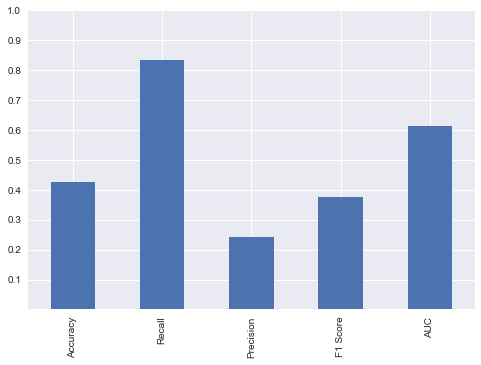

In [31]:
report_metrics(lr_cv1, X_test_scaled, y_test, append=True, model_name='lr_cv1')

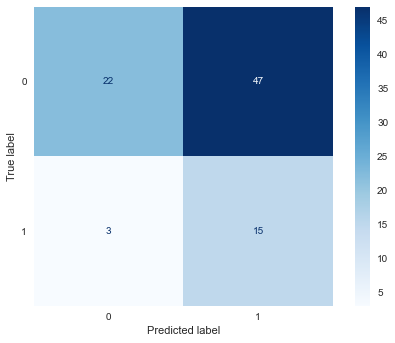

In [32]:
plot_confusion_matrix(lr_cv1, X_test_scaled, y_test, cmap='Blues')
plt.grid(None)

Accuracy     0.425287
Recall       0.833333
Precision    0.241935
F1 Score     0.375000
AUC          0.610306
dtype: float64


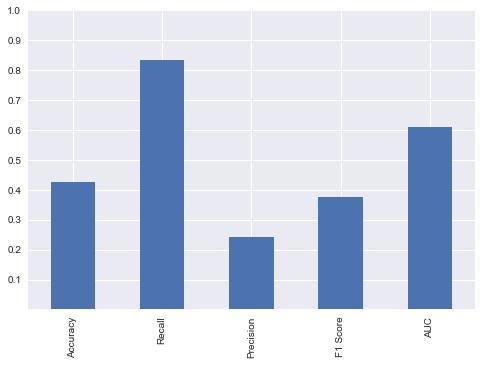

In [33]:
report_metrics(lr_cv2, X_test_scaled, y_test, append=True, model_name='lr_cv2')

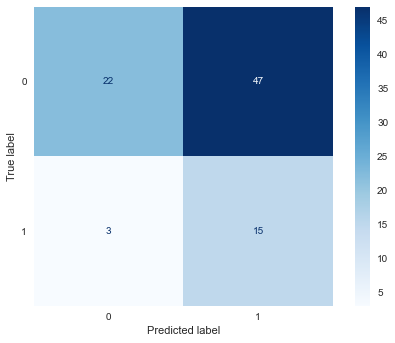

In [34]:
plot_confusion_matrix(lr_cv2, X_test_scaled, y_test, cmap='Blues')
plt.grid(None)

Both iterations of gridsearch perform almost the same. There are also no significant improvements compared to our preliminary models

# Support Vector Machine

**Preliminary SVM Model**

In [35]:
svm = SVC(random_state=seed, probability=True)
svm.fit(X_train_scaled, y_train)

svm_smote = SVC(random_state=seed, probability=True)
svm_smote.fit(X_train_res_scaled, y_train_res)

SVC(probability=True, random_state=42)

**Training Data Results**

Accuracy     0.796512
Recall       0.000000
Precision    0.000000
F1 Score     0.000000
AUC          0.189520
dtype: float64


C:\Users\Mateo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


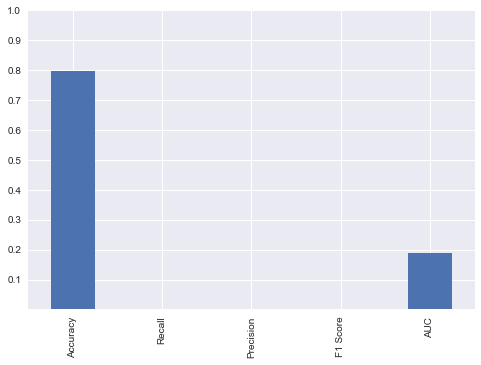

In [36]:
report_metrics(svm, X_train_scaled, y_train)

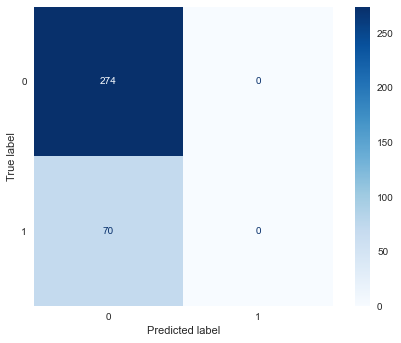

In [37]:
plot_confusion_matrix(svm, X_train_scaled, y_train, cmap='Blues')
plt.grid(None)

Accuracy     0.662409
Recall       0.912409
Precision    0.608273
F1 Score     0.729927
AUC          0.719950
dtype: float64


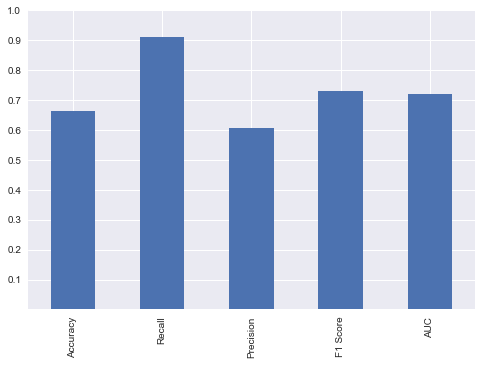

In [38]:
report_metrics(svm_smote, X_train_res_scaled, y_train_res)

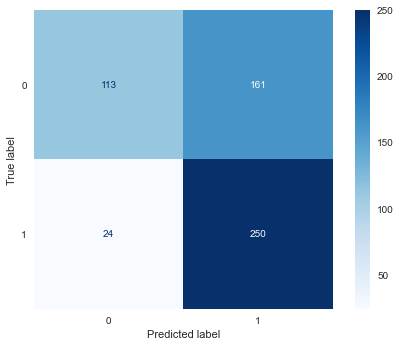

In [39]:
plot_confusion_matrix(svm_smote, X_train_res_scaled, y_train_res, cmap='Blues')
plt.grid(None)

**Testing Data Results**

Accuracy     0.793103
Recall       0.000000
Precision    0.000000
F1 Score     0.000000
AUC          0.357488
dtype: float64


C:\Users\Mateo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


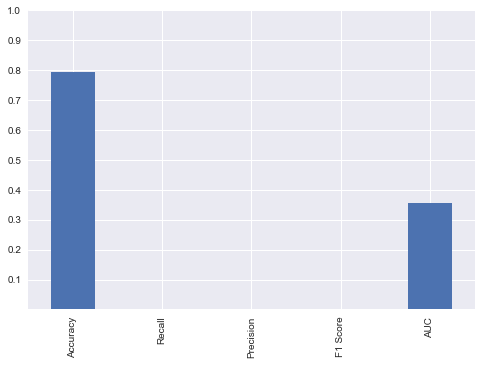

In [40]:
report_metrics(svm, X_test_scaled, y_test, append=True, model_name='svm')

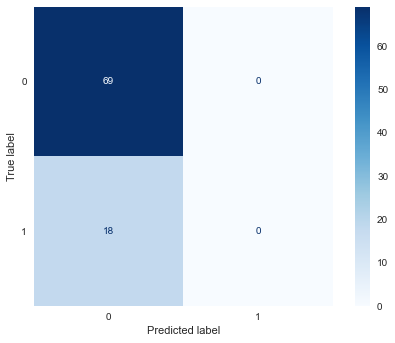

In [41]:
plot_confusion_matrix(svm, X_test_scaled, y_test, cmap='Blues')
plt.grid(None)

Accuracy     0.367816
Recall       0.888889
Precision    0.231884
F1 Score     0.367816
AUC          0.601449
dtype: float64


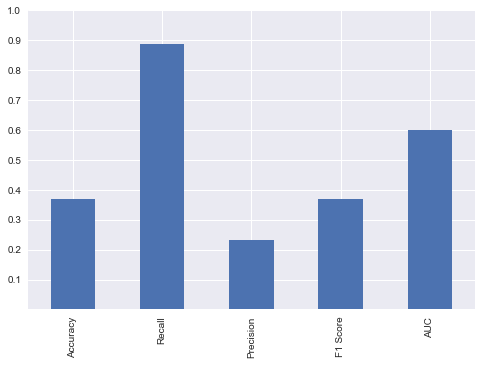

In [42]:
report_metrics(svm_smote, X_test_scaled, y_test, append=True, model_name='svm_smote')

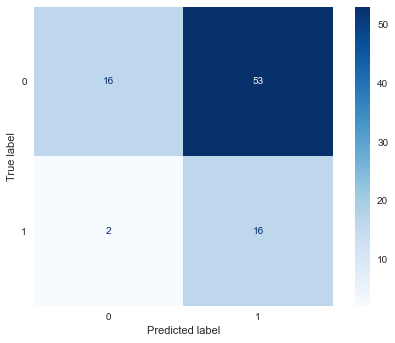

In [43]:
plot_confusion_matrix(svm_smote, X_test_scaled, y_test, cmap='Blues')
plt.grid(None)

The SVM model performs much better when the model is trained on the data modified by SMOTE. 

### Cross Validation with GridSearch

In [44]:
param_grid = {'C': [0.1, 0.5, 1, 10, 100], #adds a penalty for misclassified points. note: Values for C must be > 0
              'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001], #larger values lead to overfitting
              'kernel': ['rbf']}

svm_cv = GridSearchCV(svm_smote, param_grid=param_grid, cv=5)
svm_cv.fit(X_train_res_scaled, y_train_res)
print(svm_cv.best_params_)

{'C': 100, 'gamma': 1, 'kernel': 'rbf'}


In [45]:
param_grid = {'C': [0.1, 0.5, 1, 10, 100],
              'gamma': ['scale',1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['poly']}

svm_poly = GridSearchCV(svm_smote, param_grid=param_grid, cv=5)
svm_poly.fit(X_train_res_scaled, y_train_res)
print(svm_poly.best_params_)

{'C': 100, 'gamma': 1, 'kernel': 'poly'}


In [46]:
param_grid = {'C': [0.1, 0.5, 1, 10, 100],
              'gamma': ['scale',1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear']}

svm_cv_linear = GridSearchCV(svm_smote, param_grid=param_grid, cv=5, verbose=1)
svm_cv_linear.fit(X_train_res_scaled, y_train_res)
print(svm_cv_linear.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   11.3s finished


{'C': 100, 'gamma': 'scale', 'kernel': 'linear'}


Accuracy     0.643678
Recall       0.333333
Precision    0.240000
F1 Score     0.279070
AUC          0.574879
dtype: float64


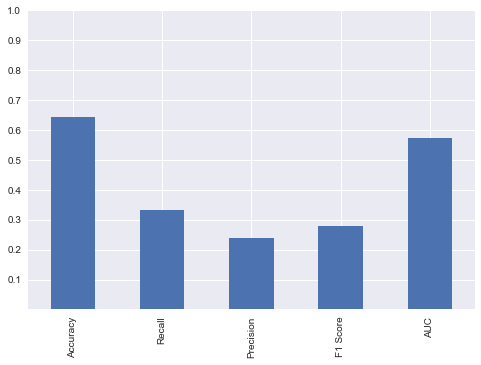

In [47]:
report_metrics(svm_cv, X_test_scaled, y_test, append=True, model_name='svm_cv')

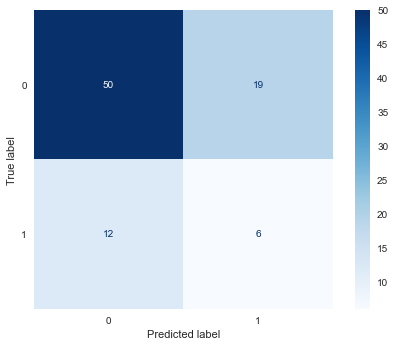

In [48]:
plot_confusion_matrix(svm_cv, X_test_scaled, y_test, cmap='Blues')
plt.grid(None)

Accuracy     0.517241
Recall       0.777778
Precision    0.269231
F1 Score     0.400000
AUC          0.524557
dtype: float64


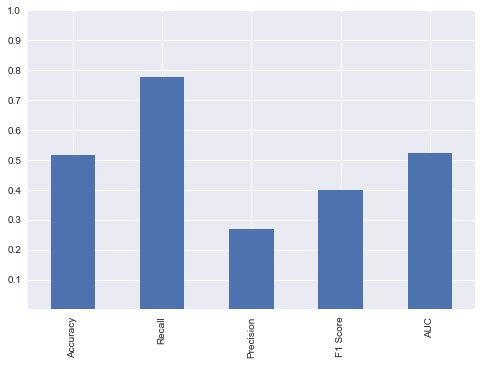

In [49]:
report_metrics(svm_poly, X_test_scaled, y_test, append=True, model_name='svm_poly')

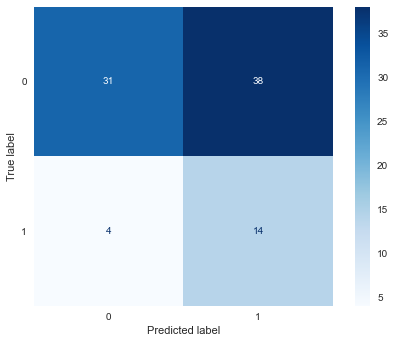

In [50]:
plot_confusion_matrix(svm_poly, X_test_scaled, y_test, cmap='Blues')
plt.grid(None)

Accuracy     0.402299
Recall       0.888889
Precision    0.242424
F1 Score     0.380952
AUC          0.628422
dtype: float64


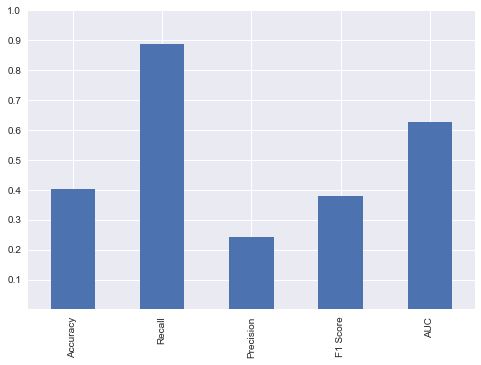

In [51]:
report_metrics(svm_cv_linear, X_test_scaled, y_test, append=True, model_name='svm_cv_linear')

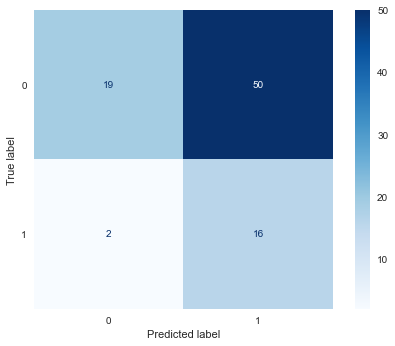

In [52]:
plot_confusion_matrix(svm_cv_linear, X_test_scaled, y_test, cmap='Blues')
plt.grid(None)

Of the three SVM models we trained, the model using a linear kernel performed the best. These results suggests that our data could have a linear decision boundary. However, the linear kernel did require more time to train than other models.

# Random Forest

**Preliminary Random Forest Model**

In [53]:
# Random forest fit without SMOTE
rf = RandomForestClassifier(random_state=seed)
rf.fit(X_train, y_train)

# random forest fit with SMOTE
rf_smote = RandomForestClassifier(random_state=seed)
rf_smote.fit(X_train_res, y_train_res)

RandomForestClassifier(random_state=42)

**Training Results**

Accuracy     1.0
Recall       1.0
Precision    1.0
F1 Score     1.0
AUC          1.0
dtype: float64


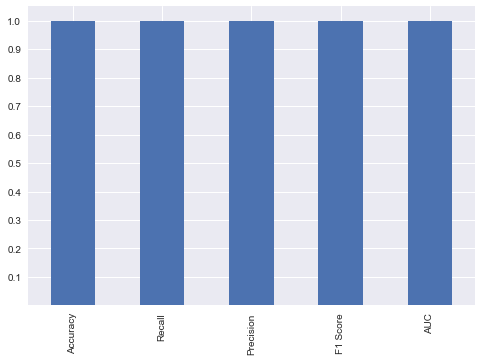

In [54]:
report_metrics(rf, X_train, y_train)

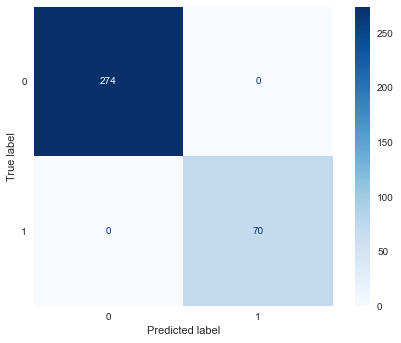

In [55]:
plot_confusion_matrix(rf, X_train, y_train, cmap='Blues')
plt.grid(None)

As expected, the preliminary random forest model will overfit to the training data

**Testing Results**

Accuracy     0.793103
Recall       0.111111
Precision    0.500000
F1 Score     0.181818
AUC          0.671095
dtype: float64


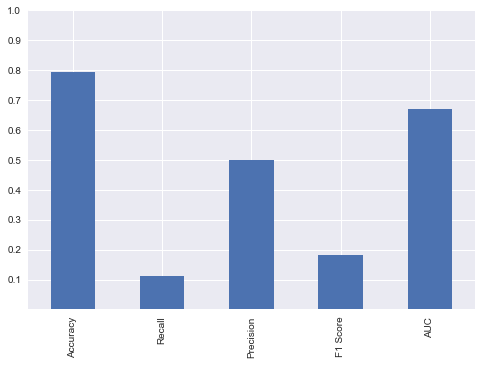

In [56]:
report_metrics(rf, X_test, y_test, append=True, model_name='rf')

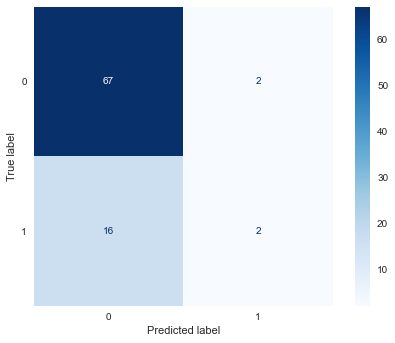

In [57]:
plot_confusion_matrix(rf, X_test, y_test, cmap='Blues')
plt.grid(None)

Accuracy     0.747126
Recall       0.444444
Precision    0.400000
F1 Score     0.421053
AUC          0.737118
dtype: float64


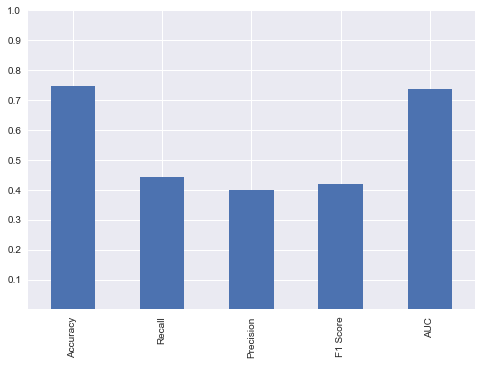

In [58]:
report_metrics(rf_smote, X_test, y_test, append=True, model_name='rf_smote')

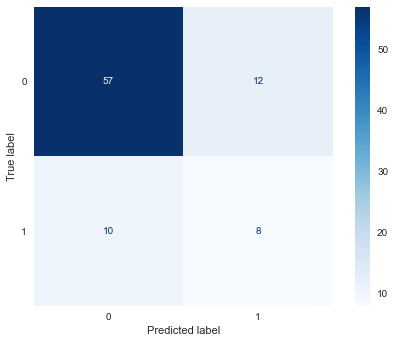

In [59]:
plot_confusion_matrix(rf_smote, X_test, y_test, cmap='Blues')
plt.grid(None)

The random forest model performs much better when the model is trained on the data modified by SMOTE. 

**Feature Importance**

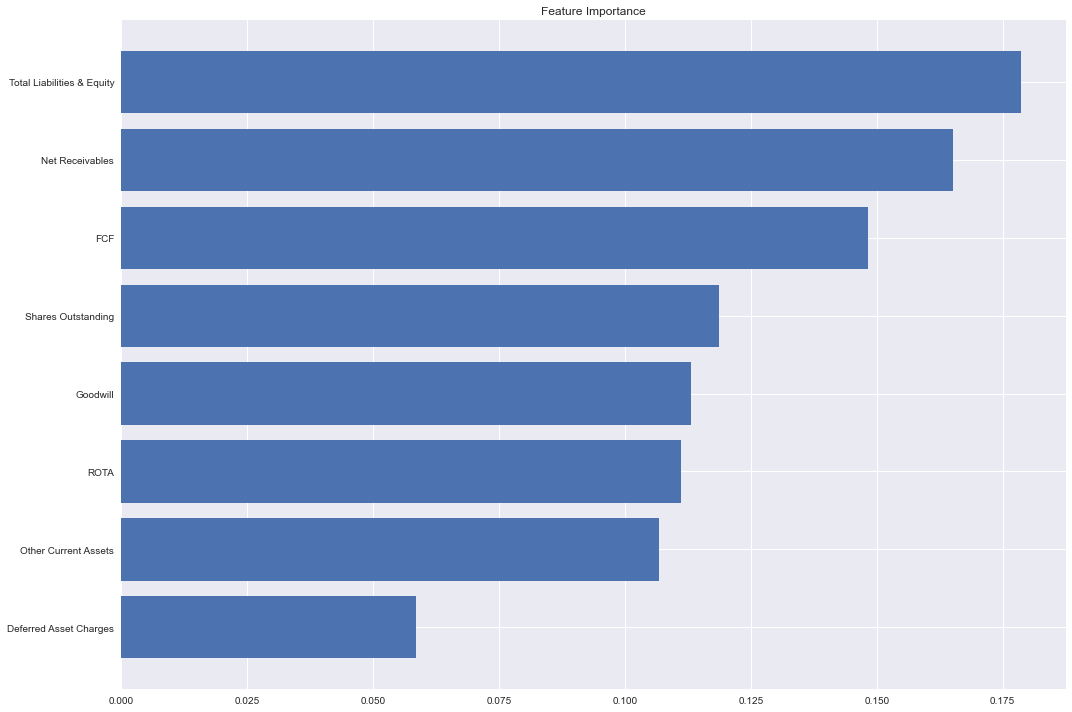

In [60]:
feature_importance = rf_smote.feature_importances_

# Return the indices that would sort the array
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(15,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

### Optimize Hyperparameters using Randomized Search and  Cross Validation


In [61]:
#Hyperparameters

# Number of trees in random forest
n_estimators=[int(x) for x in np.linspace(start=100, stop=1200, num=12)]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num=5)]
# minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15]
# minimum number of samples required at each leaf node
min_samples_leaf = [1,2, 4, 8]
# method of selecting samples for training each tree
bootstrap=[True, False]

In [62]:
# Randomized Search
param_grid = {'n_estimators':n_estimators,
              'max_features':max_features,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
              'min_samples_leaf':min_samples_leaf,
              'bootstrap':bootstrap}

rf_cv = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                             cv=5, verbose=1, n_iter=100, n_jobs=8)

rf_cv_smote = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                             cv=5, verbose=1, n_iter=100, n_jobs=8)

In [63]:
rf_cv.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    7.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   25.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   51.6s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   59.9s finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=8,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 5, 10, 15],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   verbose=1)

Accuracy     0.781609
Recall       0.000000
Precision    0.000000
F1 Score     0.000000
AUC          0.632850
dtype: float64


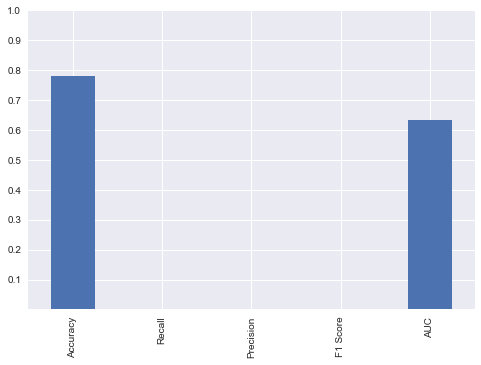

In [64]:
report_metrics(rf_cv, X_test, y_test, append=True, model_name='rf_cv')

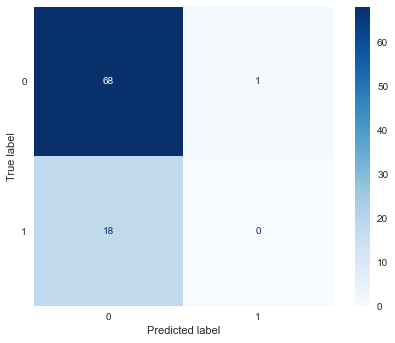

In [65]:
plot_confusion_matrix(rf_cv, X_test, y_test, cmap='Blues')
plt.grid(None)

In [66]:
rf_cv_smote.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   24.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   52.4s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:  1.0min finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=8,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 5, 10, 15],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   verbose=1)

Accuracy     0.758621
Recall       0.333333
Precision    0.400000
F1 Score     0.363636
AUC          0.700483
dtype: float64


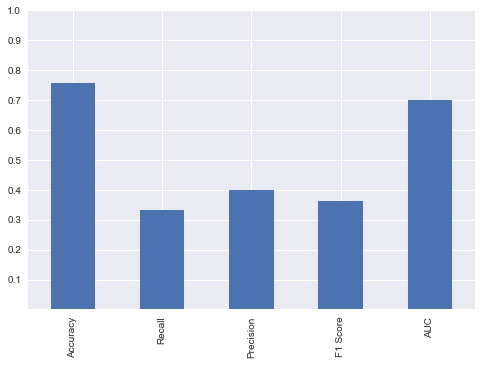

In [67]:
report_metrics(rf_cv_smote, X_test, y_test, append=True, model_name='rf_cv_smote')

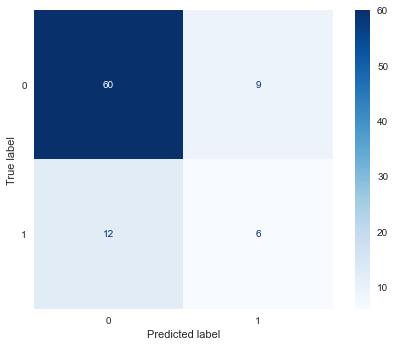

In [68]:
plot_confusion_matrix(rf_cv_smote, X_test, y_test, cmap='Blues')
plt.grid(None)

Both iterations of Random Forest excel for certain metrics and fall short for others. The model with unmodified data tends to predict zero, which leads to a very low recall score, but a high precision. A closer look through the confusion matrix shows that only four 1s were predicted. On the other hand, the model using SMOTE has a higher recall score but lower precision. The f1 score also improved. It is difficult to pick one of the two models and is dependent on the specific use case.  

# XGBoost
XGBoost is a  type of gradient boosting tree algorithm that is designed for speend and performance

In [69]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                           eval_metric='logloss',
                           seed=seed,
                           use_label_encoder=False, random_state=seed)

clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=42, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [70]:
clf_xgb_smote = xgb.XGBClassifier(objective='binary:logistic',
                           eval_metric='logloss',
                           seed=seed,
                           use_label_encoder=False, random_state=seed)

clf_xgb_smote.fit(X_train_res, y_train_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=42, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

**Training Results**

Accuracy     1.0
Recall       1.0
Precision    1.0
F1 Score     1.0
AUC          1.0
dtype: float64


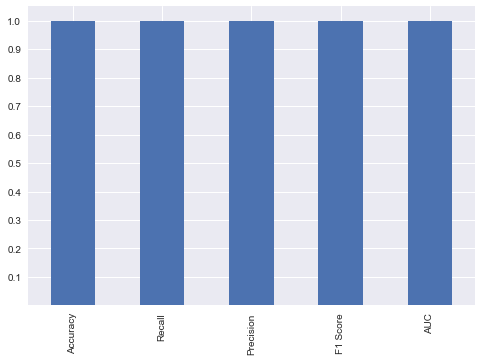

In [71]:
report_metrics(clf_xgb, X_train, y_train)

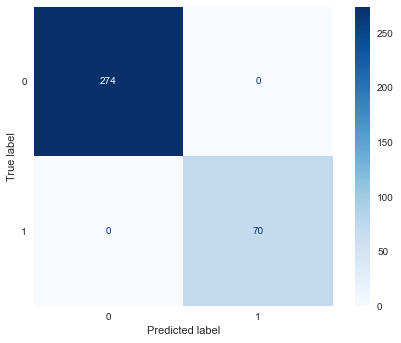

In [72]:
plot_confusion_matrix(clf_xgb, X_train, y_train, cmap='Blues')
plt.grid(None)

XGBoost like Random Forest also overfits to the training data. Let's see how it performs on the testing data

**Model Results for Testing Data**

Accuracy     0.724138
Recall       0.111111
Precision    0.200000
F1 Score     0.142857
AUC          0.681159
dtype: float64


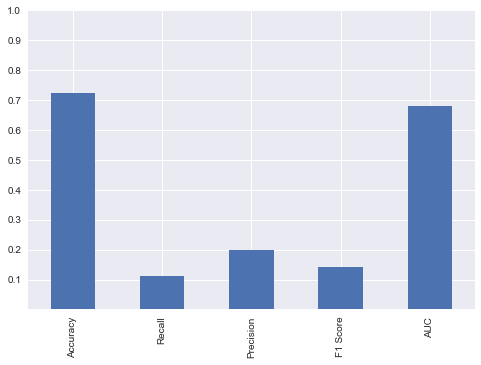

In [73]:
report_metrics(clf_xgb, X_test, y_test, append=True, model_name='clf_xgb')

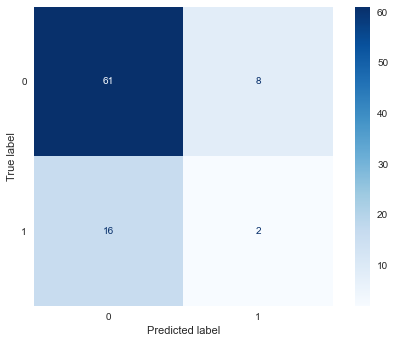

In [74]:
plot_confusion_matrix(clf_xgb, X_test, y_test, cmap='Blues')
plt.grid(None)

Accuracy     0.724138
Recall       0.388889
Precision    0.350000
F1 Score     0.368421
AUC          0.705314
dtype: float64


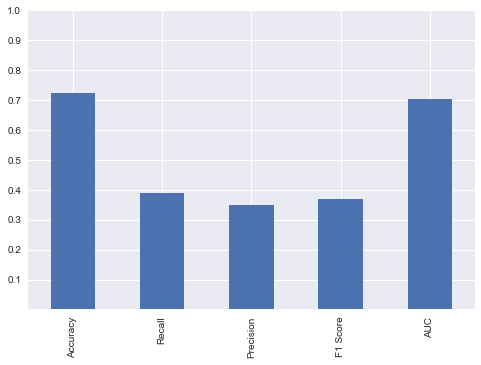

In [75]:
report_metrics(clf_xgb_smote, X_test, y_test, append=True, model_name='xgb_smote')

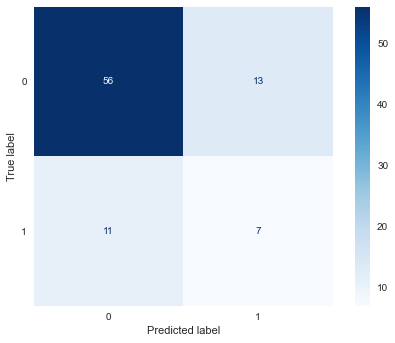

In [76]:
plot_confusion_matrix(clf_xgb_smote, X_test, y_test, cmap='Blues')
plt.grid(None)

The preliminary base model performs surprisngly well. Let's see if hyperparameter tuning improves the model at all

### Optimize Hyperparameters using Cross Validation and GridSearch

In [77]:
# Randomized Search
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8], # max depth allowed for a tree
    'n_estimators': range(5, 50, 10), # number of  trees 
    'learning_rate': [0.3, 0.1, 0.01, 0.05], # step size shrinkage; controls overfitting; range [0,1]
    'gamma': [0, 0.25, 0.5, 1.0], # minimum loss reduction for a split. higher values lead to fewer splits
    'reg_lambda': [0, 1.0, 10.0, 100.0], #L2 regularization
    'colsample_bytree':[.5, .75, 1], # percetnage of features used per tree
}

xgb_cv = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic', eval_metric="logloss", seed=seed,
                                random_state=seed, use_label_encoder=False),
    param_distributions=param_grid,
    verbose=1, # NOTE: If you want to see what Randomized Search is doing can set verbose higher
    n_jobs = 8,
    cv = 5,
    n_iter=1000)

In [78]:
xgb_cv.fit(X_train, y_train)
print(xgb_cv.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1032 tasks      | elapsed:    5.4s
[Parallel(n_jobs=8)]: Done 3032 tasks      | elapsed:   15.3s


{'reg_lambda': 10.0, 'n_estimators': 25, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.5}


[Parallel(n_jobs=8)]: Done 5000 out of 5000 | elapsed:   24.7s finished


In [79]:
xgb_cv_smote = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic', eval_metric="logloss", seed=seed,
                                random_state=seed, use_label_encoder=False),
    param_distributions=param_grid,
    verbose=1, 
    n_jobs = 8,
    cv = 5,
    n_iter=1000)


xgb_cv_smote.fit(X_train_res, y_train_res)
print(xgb_cv.best_params_)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1200 tasks      | elapsed:    7.7s
[Parallel(n_jobs=8)]: Done 3200 tasks      | elapsed:   20.3s


{'reg_lambda': 10.0, 'n_estimators': 25, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.5}


[Parallel(n_jobs=8)]: Done 4985 out of 5000 | elapsed:   32.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done 5000 out of 5000 | elapsed:   32.9s finished


Accuracy     0.770115
Recall       0.000000
Precision    0.000000
F1 Score     0.000000
AUC          0.515700
dtype: float64


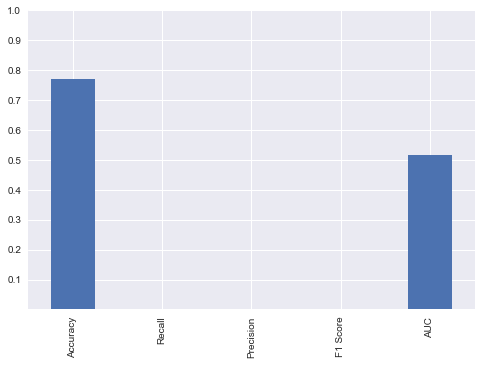

In [80]:
report_metrics(xgb_cv, X_test, y_test, append=True, model_name='xgb_cv')

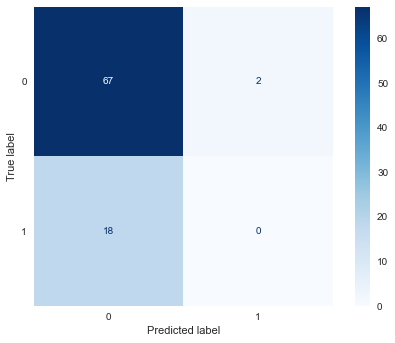

In [81]:
plot_confusion_matrix(xgb_cv, X_test, y_test, cmap='Blues')
plt.grid(None)

Accuracy     0.724138
Recall       0.388889
Precision    0.350000
F1 Score     0.368421
AUC          0.723833
dtype: float64


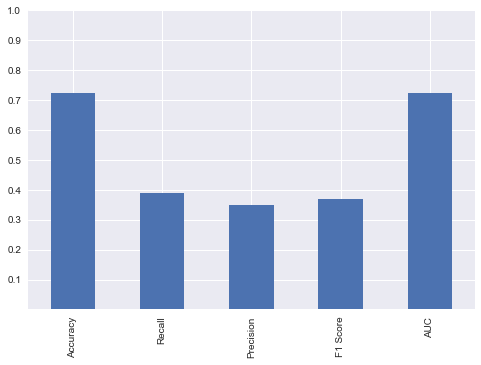

In [82]:
report_metrics(xgb_cv_smote, X_test, y_test, append=True, model_name='xgb_cv_smote')

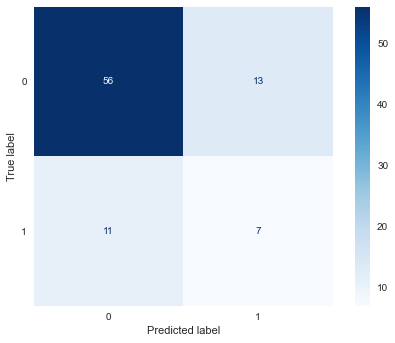

In [83]:
plot_confusion_matrix(xgb_cv_smote, X_test, y_test, cmap='Blues')
plt.grid(None)

# Summary Score Table 

In [84]:
scores_dict ={'model':list_model, 'accuracy':list_accuracy,'recall':list_recall,
                         'precision':list_precision, 'f1 score':list_f1, 'auc':list_auc}

df_scores = pd.DataFrame(scores_dict)
df_scores

,model,accuracy,recall,precision,f1 score,auc
0,lr_base,0.793103,0.000000,0.000000,0.000000,0.599839
1,lr_smote,0.436782,0.777778,0.237288,0.363636,0.607085
2,lr_cv1,0.425287,0.833333,0.241935,0.375000,0.613527
3,lr_cv2,0.425287,0.833333,0.241935,0.375000,0.610306
4,svm,0.793103,0.000000,0.000000,0.000000,0.357488
5,svm_smote,0.367816,0.888889,0.231884,0.367816,0.601449
6,svm_cv,0.643678,0.333333,0.240000,0.279070,0.574879
7,svm_poly,0.517241,0.777778,0.269231,0.400000,0.524557
8,svm_cv_linear,0.402299,0.888889,0.242424,0.380952,0.628422
9,rf,0.793103,0.111111,0.500000,0.181818,0.671095


For evaluation, we will pay particularly close attention to the F1-score as it will indicate that our model is not just predicting one class. For example for our baseline svm model, it predicts only 0, which is the majority class. Thus even though it has high accuracy, it has an f1 score of 0.

For each model type, which model performed the best?
- Logistic Regression: hyperparameter tuned logistic regression model using SMOTE (lr_cv1)

- SVM: svm model using a poly kernel that we hyperparameter tuned (svm_poly)

- Random Forest: baseline random forest using SMOTE (rf_smote)

- XGB: the hyper parameter tuned XGBoost model using SMOTE (xgb_cv_smote)

# ROC Curve

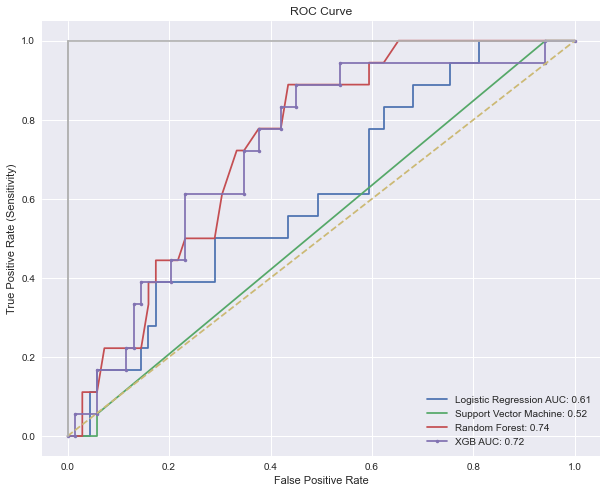

In [87]:
# Probabilities of labeled as 1
log_prob = lr_cv1.predict_proba(X_test_scaled)[:,1]
svm_prob = svm_poly.predict_proba(X_test_scaled)[:,1]
rf_prob = rf_smote.predict_proba(X_test)[:,1]
xgb_prob = xgb_cv_smote.predict_proba(X_test)[:,1]

# fpr, tpr, threshold values
log_fpr, log_tpr, log_threshold = roc_curve(y_test, log_prob)
svm_fpr, svm_tpr, svm_threshold = roc_curve(y_test, svm_prob)
rf_fpr, rf_tpr, rf_threshold = roc_curve(y_test, rf_prob)
xgb_fpr, xgb_tpr, xgb_threshold = roc_curve(y_test, xgb_prob)

# AUC Scores
lr_auc = roc_auc_score(y_test, log_prob)
svm_auc = roc_auc_score(y_test, svm_prob)
rf_auc = roc_auc_score(y_test, rf_prob)
xgb_auc = roc_auc_score(y_test, xgb_prob)
    
plt.figure(figsize=(10,8))

plt.plot(log_fpr, log_tpr, label='Logistic Regression AUC: {:.2f}'.format(lr_auc))
plt.plot(svm_fpr, svm_tpr, label='Support Vector Machine: {:.2f}'.format(svm_auc))
plt.plot(rf_fpr, rf_tpr, label='Random Forest: {:.2f}'.format(rf_auc))
plt.plot(xgb_fpr, xgb_tpr, marker='.', label='XGB AUC: {:.2f}'.format(xgb_auc))
 
plt.plot([0, 1], linestyle='--') # diagonal line indicating AUC of 0.5
plt.plot([0,0],[1, 0] , c=".7"), plt.plot([0,0],[1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend()
plt.show()

**Top Models for Each Model Type**

In [88]:
top_models = ['lr_cv1','svm_poly','rf_smote', 'xgb_cv_smote']
df_scores[df_scores['model'].isin(top_models)]

,model,accuracy,recall,precision,f1 score,auc
2,lr_cv1,0.425287,0.833333,0.241935,0.375000,0.613527
7,svm_poly,0.517241,0.777778,0.269231,0.400000,0.524557
10,rf_smote,0.747126,0.444444,0.400000,0.421053,0.737118
16,xgb_cv_smote,0.724138,0.388889,0.350000,0.368421,0.723833


### Analysis and comparison to  models built on subset vs models built on all features

In general, the top models trained on this subset of features peformed worse than the top models trained on all features. The exception is the Random Forest model slightly outperformed its counter part in its f1 score (0.42 to 0.40) and AUC score (0.73 to 0.70). 

We will most likely not use any model trained on this subset of features.